Pada sesi hands-on ini, kita akan membuat model machine learning untuk memprediksi harga median rumah di Boston.

Kita akan membuat tiga model regresi linear, yaitu Linear Regression, Lasso Regression, dan Ridge Regression. Masing-masing model ini nantinya akan kita evaluasi dan kita bandingkan performanya.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [3]:
# Import Boston Housing dataset
df = pd.read_csv('HousingData.csv')

In [4]:
# Melihat 5 baris pertama dataset
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


Dataset yang kita gunakan adalah ["Boston Housing Dataset"](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) yang memiliki 14 variabel, yaitu:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per \$10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - `1000(Bk - 0.63)^2` where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

# Data Exploration

## Statistik Deskriptif

In [5]:
# Cek jumlah baris dan kolom dataset
df.shape

(508, 14)

In [6]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     488 non-null    float64
 1   ZN       488 non-null    float64
 2   INDUS    488 non-null    float64
 3   CHAS     488 non-null    float64
 4   NOX      508 non-null    float64
 5   RM       508 non-null    float64
 6   AGE      487 non-null    float64
 7   DIS      508 non-null    float64
 8   RAD      508 non-null    int64  
 9   TAX      508 non-null    int64  
 10  PTRATIO  508 non-null    float64
 11  B        508 non-null    float64
 12  LSTAT    488 non-null    float64
 13  MEDV     508 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.7 KB


Terdapat indikasi adaya missing data pada beberapa variabel.

In [7]:
# Descriptive statistics
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,488.000000,488.000000,488.000000,488.000000,508.000000,508.000000,487.000000,508.000000,508.000000,508.000000,508.000000,508.000000,488.000000,508.000000
mean,3.597181,11.202869,11.067746,0.069672,0.554698,6.284705,68.511704,3.793084,9.515748,407.750000,18.454331,356.832402,12.689672,22.514764
std,8.705287,23.348354,6.833510,0.254855,0.115654,0.701440,27.971096,2.102373,8.706577,168.384652,2.168158,91.149501,7.153070,9.191298
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.080050,0.000000,5.175000,0.000000,0.449000,5.886500,45.250000,2.100525,4.000000,279.000000,17.375000,375.472500,7.092500,16.950000
50%,0.252775,0.000000,9.690000,0.000000,0.538000,6.208500,76.700000,3.207450,5.000000,330.000000,19.050000,391.475000,11.395000,21.200000
75%,3.543427,12.500000,18.100000,0.000000,0.624000,6.620500,93.950000,5.141475,24.000000,666.000000,20.200000,396.250000,16.945000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Beberapa hal yang dapat kita observasi dari statistik deskriptif:
* `CRIM`: Nilai mean secara signifikan lebih tinggi dari median, yang mengindikasikan distribusi yang skewed dan adanya outliers.
* `ZN`: Distribusi juga skewed, dengan banyak nilai 0.
* `CHAS`: Categorical variable dengan mayoritas nilai 0.

## Cek Data Duplikat

In [8]:
# Cek data duplikat
df.duplicated().sum()

2

Terdapat 2 data duplikat dalam dataset yang kita gunakan. Dalam kasus ini, kita akan drop data duplikat tersebut.

In [9]:
# Drop data duplikat
df = df.drop_duplicates()

In [10]:
# Cek jumlah row setelah drop duplikat
df.shape

(506, 14)

## Cek Missing Data

In [11]:
# Cek missing data
df.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

Terdapat beberapa kolom yang memiliki missing data di dalamnya, yaitu:
* `CRIM`, `ZN`, `INDUS`, `CHAS`, `AGE`, `LSTAT`: Each has 20 missing values.

Karena jumlah data yang hilang relatif sedikit, kita akan menggunakan metode imputasi median untuk variabel kontinu dan imputasi modus untuk variabel kategori.

In [12]:
# Buat list yang berisi kolom numerik
cont_cols = ['CRIM', 'ZN', 'INDUS', 'AGE', 'LSTAT']

# Imputasi missing data numerik dengan nilai median
for col in cont_cols:
  df[col] = df[col].fillna(df[col].median())

# Imputasi missing data kategori dengan nilai modus
df['CHAS'] = df['CHAS'].fillna(df['CHAS'].mode()[0])

In [13]:
# Cek kembali missing data setelah impute
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Cek Outlier

Untuk mengecek adanya outlier, kita dapat membuat visualisasi boxplot.

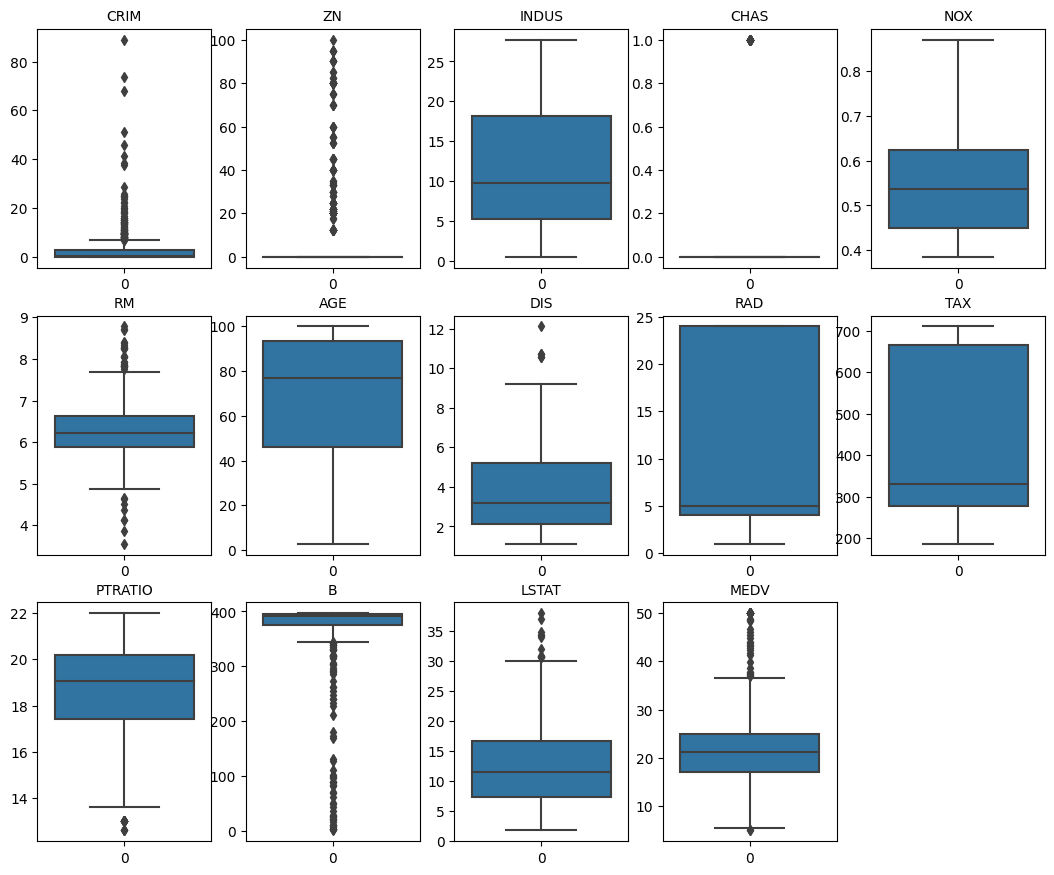

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat visualisasi boxplot per kolom
plt.figure(figsize=(13, 18))

for idx, column in enumerate(df.columns, 1): # enumerate() mengiterasi objek dan indeksnya
    plt.subplot(5, 5, idx)
    sns.boxplot(df[column])
    plt.title(column, fontsize=10)

plt.show()

Beberapa hal yang dapat kita observasi:
* Terdapat beberapa kolom yang terindikasi memiliki outlier, yaitu `CRIM`, `ZN`, `RM`, `DIS`, `PTRATIO`, `B`, dan `LSTAT`.
* Kolom `RM` memiliki outlier rendah dan tinggi.

Dalam latihan ini, kita akan melakukan transformasi logaritma pada fitur-fitur yang memiliki outlier yang cukup signifkan, yaitu `CRIM`, `ZN`, `B`, dan `LSTAT`.

In [15]:
# Buat list berisi kolom yang akan ditransform
cols_to_transform = ['CRIM', 'ZN', 'B', 'LSTAT']

# Lakukan iterasi atas log transform pada setiap kolom
for col in cols_to_transform:
  df[col] = np.log1p(df[col])

## Cek Multikolinearitas

Multikolinearitas adalah kondisi di mana dua atau lebih variabel independen dalam model memiliki hubungan yang kuat satu sama lain. Kondisi ini dapat mengganggu interpretasi model, membuat koefisien variabel menjadi tidak stabil, dan mempersulit identifikasi kontribusi individu dari setiap variabel terhadap variabel target.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Menghitung VIF scores untuk setiap feature
df_vif = add_constant(df)

check_vif = pd.DataFrame([vif(df_vif.values, i)
               for i in range(df_vif.shape[1])],
              index=df_vif.columns).reset_index()
check_vif.columns = ['feature','vif_score']
check_vif = check_vif.loc[check_vif.feature!='const']
check_vif

,feature,vif_score
1,CRIM,5.335588
2,ZN,2.327901
3,INDUS,3.594430
4,CHAS,1.094984
5,NOX,4.429265
6,RM,2.242639
7,AGE,2.826319
8,DIS,4.218977
9,RAD,9.713766
10,TAX,8.663791


Kita lihat bahwa `TAX` dan `RAD` mempunyai nilai vif score cukup tinggi. Kita juga dapat menganalisis indikasi multikorelasi dengan membuat correlation heatmap.

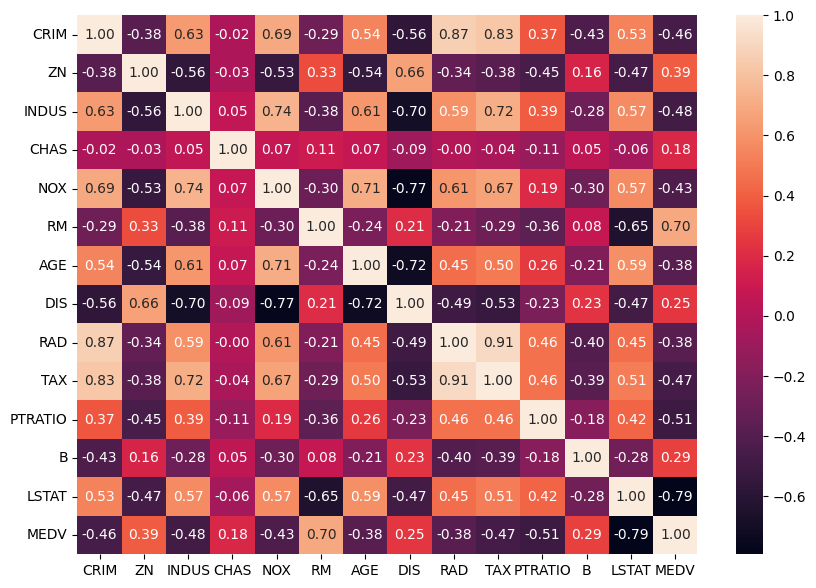

In [17]:
# Membuat correlation heatmap
corr = df.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

`TAX` dan `RAD` mempunyai korelasi yang kuat. `TAX` mempunyai korelasi yang lebih kuat terhadap target yaitu `MEDV` dibandingkan `RAD`, sehingga dipilih `RAD` untuk didrop.

In [18]:
# Drop kolom RAD
df = df.drop(columns=['RAD'])

Kita dapat mengecek ulang vif score untuk memastikan kondisi multikolinearitas.

In [19]:
# Menghitung ulang vif score
df_vif = add_constant(df)

check_vif = pd.DataFrame([vif(df_vif.values, i)
               for i in range(df_vif.shape[1])],
              index=df_vif.columns).reset_index()
check_vif.columns = ['feature','vif_score']
check_vif = check_vif.loc[check_vif.feature!='const']
check_vif

,feature,vif_score
1,CRIM,3.833971
2,ZN,2.327123
3,INDUS,3.407535
4,CHAS,1.085864
5,NOX,4.415047
6,RM,2.227438
7,AGE,2.797967
8,DIS,4.218467
9,TAX,4.453169
10,PTRATIO,1.928230


Tidak ada lagi vif score yang tinggi.

# Model Preparation

## Split Feature dan Target

Sebelum melakukan prediksi, terlebih dahulu harus ditentukan mana kolom yang menjadi feature dan target.

Dalam hal ini kita akan menggunakan `MEDV` sebagai target dan lainnya sebagai feature.

In [20]:
# Memisahkan kolom feature dan target
X = df.drop(columns='MEDV') # Feature untuk memprediksi
y = df[['MEDV']] # Target yang akan diprediksi

In [21]:
# Mengecek subset feature (X)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
0,0.006300,2.944439,2.31,0.0,0.538,6.575,65.2,4.0900,296,15.3,5.986201,1.788421
1,0.026944,0.000000,7.07,0.0,0.469,6.421,78.9,4.9671,242,17.8,5.986201,2.316488
2,0.026924,0.000000,7.07,0.0,0.469,7.185,61.1,4.9671,242,17.8,5.975919,1.615420
3,0.031857,0.000000,2.18,0.0,0.458,6.998,45.8,6.0622,222,18.7,5.980479,1.371181
4,0.066770,0.000000,2.18,0.0,0.458,7.147,54.2,6.0622,222,18.7,5.986201,2.520113


In [22]:
# Mengecek subset target (y)
y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


## Train-Test-Validation Split

Selanjutnya, kita akan membagi data menjadi training dan testing set.

Rasio pembagian yang kita gunakan adalah 80/20, yang berarti 80% dari data digunakan untuk pelatihan, dan sisanya 20% digunakan untuk pengujian.

In [23]:
from sklearn.model_selection import train_test_split

# Lakukan train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
# Cek jumlah data masing-masing subset
X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((404, 12), (102, 12), (404, 1), (102, 1))

# Linear Regression

**Model Training:**

Model pertama yang akan kita buat adalah model linear regresi yang standar.

In [25]:
from sklearn.linear_model import LinearRegression

# Tentukan model yang akan digunakan
lin_reg = LinearRegression()

# Train Model
lin_reg.fit(X_train, y_train)

LinearRegression()

In [26]:
# Menampilkan intercept dan koefisien model
intercept_lin = lin_reg.intercept_
coeff_lin = lin_reg.coef_

print(intercept_lin, coeff_lin)

[38.94241415] [[-4.67048642e-01  2.43809165e-01 -7.88219282e-02  3.35872697e+00
  -1.22013047e+01  3.76806315e+00 -2.55403918e-03 -1.38968227e+00
   1.03578978e-04 -6.75970361e-01  1.17691996e+00 -8.66566655e+00]]


**Model Evaluation:**

Kita akan mengevaluasi kinerja model dengan menghitung Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) dan R2.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Menggunakan model yang sudah dilatih untuk memprediksi testing dataset
y_pred_lin = lin_reg.predict(X_test)

# Menghitung MAE, RMSE, dan R2
mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print('MAE for testing data is {}'.format(mae_lin))
print('RMSE for testing data is {}'.format(rmse_lin))
print('R-squared for testing data is {}'.format(r2_lin))

MAE for testing data is 3.022981191591306
RMSE for testing data is 4.636388365842755
R-squared for testing data is 0.7068732015103176


# Lasso Regression (L1)

## Standard Lasso Regression (L1)

**Model Training:**

Membuat model Lasso Regression standar (L1 Regularization).

In [28]:
from sklearn.linear_model import Lasso

# Tentukan model yang akan digunakan
lasso_reg = Lasso()

# Train model
lasso_reg.fit(X_train, y_train)

Lasso()

**Model Evaluation:**

Kita akan mengevaluasi kinerja model dengan menghitung Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) dan R2.

In [29]:
# Predict on the testing data
y_pred_lasso = lasso_reg.predict(X_test)

# Evaluasi kinerja model
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print('MAE for testing data is {}'.format(mae_lasso))
print('RMSE for testing data is {}'.format(rmse_lasso))
print('R-squared for testing data is {}'.format(r2_lasso))

MAE for testing data is 3.123918769380426
RMSE for testing data is 5.062025386700618
R-squared for testing data is 0.6505825840243109


Kita lihat bahwa nilai error model standard Lasso Regression lebih tinggi dibanding nilai error pada model Linear Regression biasa.

Estimator Lasso menggunakan nilai default `alpha=1.0`, yang mungkin bukan nilai optimal untuk regularisasi. Untuk itu, kita akan coba melakukan tuning parameter lambda.

## Lasso Regression dengan Cross Validation

Kita akan menggunakan metode validasi silang (cross-validation) untuk menemukan nilai alpha yang optimal dengan `LassoCV()`.

In [34]:
from sklearn.linear_model import LassoCV

# Tentukan rentang nilai alpha untuk Lasso
alphas_lasso = np.logspace(-1, 1, 100)

# Tentukan model yang akan digunakan
lasso_cv = LassoCV(alphas=alphas_lasso, cv=5)

# Train the model on the training data
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.38535286,
        0.40370...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
        cv=5)

Kita akan mengevaluasi kinerja model dengan menghitung Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) dan R2.

In [35]:
# Menggunakan model yang sudah dilatih untuk memprediksi testing dataset
y_pred_lasso_cv = lasso_cv.predict(X_test)

# Evaluasi kinerja model
mae_lasso_cv = mean_absolute_error(y_test, y_pred_lasso_cv)
rmse_lasso_cv = np.sqrt(mean_squared_error(y_test, y_pred_lasso_cv))
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)

# Optimal alpha value
optimal_alpha_lasso = lasso_cv.alpha_

print('The optimal alpha is {}'.format(optimal_alpha_lasso))
print('MAE for testing data is {}'.format(mae_lasso_cv))
print('RMSE for testing data is {}'.format(rmse_lasso_cv))
print('R-squared for testing data is {}'.format(r2_lasso_cv))

The optimal alpha is 0.1
MAE for testing data is 2.976646190698473
RMSE for testing data is 4.681330725460596
R-squared for testing data is 0.7011628690527124


# Ridge Regression

## Standard Ridge Regression (L2)




**Model Training:**

Membuat model Ridge Regression standar (L2 Regularization).

In [37]:
from sklearn.linear_model import Ridge

# Tentukan model yang akan digunakan
ridge_reg = Ridge()

# Train model
ridge_reg.fit(X_train, y_train)

Ridge()

**Model Evaluation:**

Kita akan mengevaluasi kinerja model dengan menghitung Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) dan R2.

In [38]:
# Predict on the testing data
y_pred_ridge = ridge_reg.predict(X_test)

# Evaluasi kinerja model
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print('MAE for testing data is {}'.format(mae_ridge))
print('RMSE for testing data is {}'.format(rmse_ridge))
print('R-squared for testing data is {}'.format(r2_ridge))

MAE for testing data is 3.021435715702143
RMSE for testing data is 4.6632520078639565
R-squared for testing data is 0.7034665559077171


## Ridge Regression dengan Cross Validation

Kita akan menggunakan metode validasi silang (cross-validation) untuk menemukan nilai alpha yang optimal dengan `RidgeCV()`.

In [41]:
from sklearn.linear_model import RidgeCV

# Tentukan rentang nilai alpha untuk Ridge
alphas_ridge = np.logspace(-1, 1, 100)

# Tentukan model yang akan digunakan
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5)

# Train the model on the training data
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.38535286,
        0.40370...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
        cv=5)

Kita akan mengevaluasi kinerja model dengan menghitung Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) dan R2.

In [42]:
# Predict on the testing data
y_pred_ridge_reg = ridge_cv.predict(X_test)

# Evaluasi kinerja model
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_reg)
rmse_ridge_cv = np.sqrt(mean_squared_error(y_test, y_pred_ridge_reg))
r2_ridge_cv = r2_score(y_test, y_pred_ridge_reg)

# Optimal alpha value
optimal_alpha_ridge = ridge_cv.alpha_

print('The optimal alpha is {}'.format(optimal_alpha_ridge))
print('MAE for testing data is {}'.format(mae_ridge_cv))
print('RMSE for testing data is {}'.format(rmse_ridge_cv))
print('R-squared for testing data is {}'.format(r2_ridge_cv))

The optimal alpha is 0.1
MAE for testing data is 3.020716628311701
RMSE for testing data is 4.639356314503538
R-squared for testing data is 0.7064977956221252


# Penutup

## Summary Model Performance

**Linear Regression:**

* MAE: 3.0230
* RMSE: 4.6364
* R-squared: 0.7069

---

**Lasso Regression:**

* MAE: 3.1239
* RMSE: 5.0620
* R-squared: 0.6506

---

**Lasso Regression with CV:**
(optimal alpha = 0.1)

* MAE: 2.9766
* RMSE: 4.6813
* R-squared: 0.7012

---

**Ridge Regression:**

* MAE: 3.0214
* RMSE: 4.6632
* R-squared: 0.7035

---

**Ridge Regression with CV:**
(optimal alpha = 0.1)

* MAE: 3.0207
* RMSE: 4.6394
* R-squared: 0.7065

## Kesimpulan

Dari hasil di atas, beberapa kesimpulan umum dalam project ini antara lain:

* Semua model menunjukkan kinerja yang cukup baik dengan nilai R-squared di atas 0.65.
* Model Linear Regression, Ridge Regression, dan Ridge Regression dengan CV menunjukkan kinerja yang hampir serupa dan lebih baik dibandingkan model Lasso Regression.
* Model Lasso Regression dengan CV memiliki nilai MAE yang paling rendah.
* Penggunaan cross-validation untuk menentukan parameter alpha pada Lasso dan Ridge membantu meningkatkan kinerja model.